In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from ydata_profiling import ProfileReport  
import mlflow
from mlflow.models import infer_signature
import joblib
import sqlite3
from sqlite3 import Error
from xgboost import XGBClassifier
%matplotlib inline

In [13]:
# Load dataset
beforeDataClean = pd.read_csv(r".\diabetes.csv")

In [ ]:

# Generate Profile Report
print("Generating profile report...")
profile = ProfileReport(beforeDataClean, title="Diabetes Dataset Profiling Report")
profile.to_notebook_iframe()
# Compute the correlation matrix for numerical columns
numerical_columns = beforeDataClean.select_dtypes(include=['number'])
correlation_matrix = numerical_columns.corr()
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
# Data Cleaning
afterDataClean = beforeDataClean.copy(deep=True)
afterDataClean[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = (
    afterDataClean[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN))
afterDataClean['Glucose'] = afterDataClean['Glucose'].fillna(round(afterDataClean['Glucose'].mean()))
afterDataClean['BloodPressure'] = afterDataClean['BloodPressure'].fillna(round(afterDataClean['BloodPressure'].mean()))
afterDataClean['SkinThickness'] = afterDataClean['SkinThickness'].fillna(round(afterDataClean['SkinThickness'].median()))
afterDataClean['Insulin'] = afterDataClean['Insulin'].fillna(round(afterDataClean['Insulin'].median()))
afterDataClean['BMI'] = afterDataClean['BMI'].fillna(round(afterDataClean['BMI'].median()))

# Check for remaining NaN values
print("Remaining NaN values:", afterDataClean.isnull().sum())


# Final data for processing
data = afterDataClean

In [ ]:
# Database Connection Functions
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)
    return conn

def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

# Create database and tables
dbConnection = create_connection("normalizedData.db", True)

patientTable = '''CREATE TABLE Patient (
    PatientID INTEGER PRIMARY KEY AUTOINCREMENT,
    Pregnancies INTEGER,
    Age INT
);'''
healthMatrixTable = '''CREATE TABLE HealthMetrics (
    PatientID INTEGER,
    Glucose INTEGER,
    BloodPressure INTEGER,
    SkinThickness INTEGER,
    Insulin INTEGER,
    BMI FLOAT,
    DiabetesPedigreeFunction FLOAT,
    FOREIGN KEY (PatientID) REFERENCES Patient(PatientID)
);'''
diseaseOutcomeTable = '''CREATE TABLE Outcome (
    PatientID INTEGER,
    DiabetesStatus INTEGER,
    FOREIGN KEY (PatientID) REFERENCES Patient(PatientID)
);'''

create_table(dbConnection, patientTable)
create_table(dbConnection, healthMatrixTable)
create_table(dbConnection, diseaseOutcomeTable)

# Insert data into tables
def insert_patient_data(conn, data):
    cursor = conn.cursor()
    for _, row in data.iterrows():
        cursor.execute(
            "INSERT INTO Patient (Pregnancies, Age) VALUES (?, ?)",
            (row["Pregnancies"], row["Age"])
        )
    conn.commit()

def insert_health_metrics(conn, data):
    cursor = conn.cursor()
    patient_ids = cursor.execute("SELECT PatientID FROM Patient").fetchall()
    for _, (row, patient_id) in enumerate(zip(data.iterrows(), patient_ids)):
        row = row[1]
        cursor.execute(
            """
            INSERT INTO HealthMetrics (
                PatientID, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction
            ) VALUES (?, ?, ?, ?, ?, ?, ?)
            """,
            (
                patient_id[0],
                row["Glucose"],
                row["BloodPressure"],
                row["SkinThickness"],
                row["Insulin"],
                row["BMI"],
                row["DiabetesPedigreeFunction"]
            )
        )
    conn.commit()

def insert_outcome(conn, data):
    cursor = conn.cursor()
    patient_ids = cursor.execute("SELECT PatientID FROM Patient").fetchall()
    for _, (row, patient_id) in enumerate(zip(data.iterrows(), patient_ids)):
        row = row[1]
        cursor.execute(
            "INSERT INTO Outcome (PatientID, DiabetesStatus) VALUES (?, ?)",
            (patient_id[0], row["Outcome"])
        )
    conn.commit()

insert_patient_data(dbConnection, data)
insert_health_metrics(dbConnection, data)
insert_outcome(dbConnection, data)
print("Data inserted successfully!")

# Load data from database
dataFromTable = '''SELECT 
    p.PatientID, 
    p.Pregnancies, 
    p.Age, 
    hm.Glucose, 
    hm.BloodPressure, 
    hm.SkinThickness, 
    hm.Insulin, 
    hm.BMI, 
    hm.DiabetesPedigreeFunction, 
    o.DiabetesStatus AS Outcome
FROM Patient p
JOIN HealthMetrics hm ON p.PatientID = hm.PatientID
JOIN Outcome o ON p.PatientID = o.PatientID;'''
data = pd.read_sql_query(dataFromTable, dbConnection)
print(data.head())
dbConnection.close()
print(data.describe())

In [ ]:
# Split features and target
X = data.drop(['Outcome','PatientID'], axis=1)
y = data['Outcome']

# Feature Engineering (Experiment #3)
data['Age_BMI'] = data['Age'] * data['BMI']
data['Glucose_BloodPressure'] = data['Glucose'] * data['BloodPressure']

# Handle imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("Class distribution after SMOTE:", np.bincount(y_res))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Define Pipeline Steps
scaler = StandardScaler()
pca = PCA(n_components=0.95)
feature_selector = VarianceThreshold(threshold=0.01)

In [18]:
# Models
log_reg = LogisticRegression(max_iter=200, random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
ridge = RidgeClassifier(random_state=42)
random_forest = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Custom Experiments (Experiment #6 and #7)
stacking_clf = StackingClassifier(
    estimators=[('rf', random_forest), ('gb', gb)], final_estimator=LogisticRegression(),
    passthrough=True
)
custom_xgb = XGBClassifier(n_estimators=300, max_depth=15, learning_rate=0.05, random_state=42)


In [19]:
# Define Pipelines
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', log_reg)
    ]),
    'Ridge Classifier': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', ridge)
    ]),
    'Random Forest': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', random_forest)
    ]),
    'XGBClassifier': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', xgb)
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', gb)
    ]),
    'Stacking': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', stacking_clf)
    ]),
    'Custom XGB': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', custom_xgb)
    ])
}

In [20]:
results = {}
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [ ]:
MLFLOW_TRACKING_URI = "https://dagshub.com/s3akash/diseasePredictionSystemModel.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 's3akash'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '4d779774d517aa973e2858c5d93af0e87a4ca457'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("diseasePredictionSystemModel")
for name, pipeline in pipelines.items():
    cv_f1_scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='f1')
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {
        'Mean CV F1 Score': cv_f1_scores.mean(),
        'Std CV F1 Score': cv_f1_scores.std(),
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Confusion Matrix': cm,
        'TP': cm[1, 1],
        'TN': cm[0, 0],
        'FP': cm[0, 1],
        'FN': cm[1, 0]
    }
# Log metrics
    mlflow.log_metric("mean_cv_f1_score", cv_f1_scores.mean())
    mlflow.log_metric("std_cv_f1_score", cv_f1_scores.std())
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred))
    mlflow.log_metric("true_positives", cm[1, 1])
    mlflow.log_metric("true_negatives", cm[0, 0])
    mlflow.log_metric("false_positives", cm[0, 1])
    mlflow.log_metric("false_negatives", cm[1, 0])

    signature = infer_signature(X_train, pipeline.predict(X_train))
        
    # Log the model
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="model",
        signature=signature,
        input_example=X_train,
        registered_model_name=name,
    )
    

                    Mean CV F1 Score Std CV F1 Score Accuracy  F1 Score  \
Logistic Regression         0.724046          0.0518    0.745  0.753623   
Ridge Classifier            0.711978        0.059794     0.75  0.754902   
Random Forest               0.794854        0.062576    0.785  0.807175   
XGBClassifier               0.791712        0.052744     0.79  0.801887   
Gradient Boosting           0.771374        0.046129     0.76  0.779817   
Stacking                    0.786486        0.051623     0.79  0.809091   
Custom XGB                  0.791181        0.057984    0.805  0.820276   

                         Confusion Matrix  TP  TN  FP  FN  
Logistic Regression  [[71, 28], [23, 78]]  78  71  28  23  
Ridge Classifier     [[73, 26], [24, 77]]  77  73  26  24  
Random Forest        [[67, 32], [11, 90]]  90  67  32  11  
XGBClassifier        [[73, 26], [16, 85]]  85  73  26  16  
Gradient Boosting    [[67, 32], [16, 85]]  85  67  32  16  
Stacking             [[69, 30], [12, 89

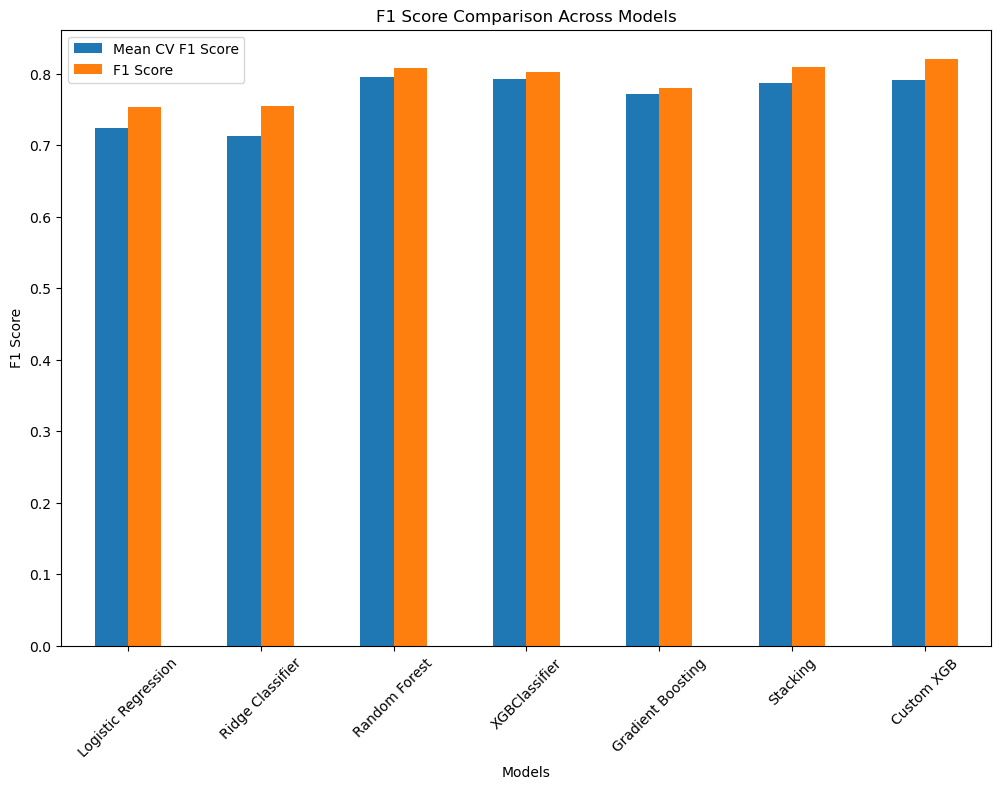

Best Model: Custom XGB


In [26]:

# Generate F1-score plot
results_df = pd.DataFrame(results).T
print(results_df)
results_df[['Mean CV F1 Score', 'F1 Score']].plot(kind='bar', figsize=(12, 8))
plt.title('F1 Score Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()

# Save best model
best_model_name = results_df['Accuracy'].idxmax()
joblib.dump(pipelines[best_model_name], './disease_prediction_model2.pkl')
print(f"Best Model: {best_model_name}")

In [ ]:
# Test Cases
def test_model(model_pipeline, test_cases, feature_columns):
    for i, test_case in enumerate(test_cases):
        # Add feature engineering
        test_case['Age_BMI'] = test_case['Age'] * test_case['BMI']
        test_case['Glucose_BloodPressure'] = test_case['Glucose'] * test_case['BloodPressure']
        # Reorder columns to match training
        test_case = test_case[feature_columns]
        print(test_case)
        prediction = model_pipeline.predict(test_case)
        print(f"Test Case {i+1}: Input: {test_case.values.flatten().tolist()}, Prediction: {prediction[0]}")

# Example Test Cases
test_case_1 = pd.DataFrame({
    'Pregnancies': [1],
    'Age': [22],
    'Glucose': [85],
    'BloodPressure': [70],
    'SkinThickness': [20],
    'Insulin': [50],
    'BMI': [25.5],
    'DiabetesPedigreeFunction': [0.201]
})

test_case_2 = pd.DataFrame({
    'Pregnancies': [5],
    'Age': [45],
    'Glucose': [165],
    'BloodPressure': [85],
    'SkinThickness': [40],
    'Insulin': [150],
    'BMI': [35.0],
    'DiabetesPedigreeFunction': [0.543]
})

test_case_3 = pd.DataFrame({
    'Pregnancies': [3],
    'Age': [33],
    'Glucose': [110],
    'BloodPressure': [70],
    'SkinThickness': [25],
    'Insulin': [90],
    'BMI': [28.0],
    'DiabetesPedigreeFunction': [0.350]
})

test_case_4 = pd.DataFrame({
    'Pregnancies': [0],
    'Age': [19],
    'Glucose': [75],
    'BloodPressure': [60],
    'SkinThickness': [18],
    'Insulin': [40],
    'BMI': [22.0],
    'DiabetesPedigreeFunction': [0.150]
})

test_case_5 = pd.DataFrame({
    'Pregnancies': [8],
    'Age': [50],
    'Glucose': [180],
    'BloodPressure': [90],
    'SkinThickness': [45],
    'Insulin': [230],
    'BMI': [40.0],
    'DiabetesPedigreeFunction': [0.750]
})

test_cases = [test_case_1, test_case_2, test_case_3, test_case_4, test_case_5]

# Evaluate Best Model
feature_columns = X_train.columns.tolist()
best_pipeline = pipelines[best_model_name]
test_model(best_pipeline, test_cases, feature_columns)

In [2]:
import requests
import json

# Define test payload
test_case = {
    "Pregnancies": 8,
    "Age": 50,
    "Glucose": 180,
    "BloodPressure": 90,
    "SkinThickness": 45,
    "Insulin": 230,
    "BMI": 40.0,
    "DiabetesPedigreeFunction": 0.750
}
# Make POST request
response = requests.post("http://159.203.101.120:8008/predict", json=test_case)

# Print response
print("Status Code:", response.status_code)
print("Response JSON:", response.json())

Status Code: 200
Response JSON: {'prediction': 1}
